# Integrazione C-Python / Compilazione just-in-time

In [1]:
import sys,os
import numpy as np

Come detto diverse volte nel corso delle lezioni passate le principali librerie scientifiche in python (*numpy*, *scipy*, *pandas* e altre) forniscono spesso un interfaccia python a funzioni scritte in lingiaggi compilati come C e Fortran per velocizzare e rendere più efficiente la parte di calcolo vero e proprio. 

Un altro motivo per interfacciare C/C++ e python potrebbe essere quello di utlizzare librerie sftware già esistenti. 

Esitono diversi modi per interfacciare python con C o C++. Per una decrizione delle possibili scelte vedere ad esempio  https://scipy-lectures.org/advanced/interfacing_with_c/interfacing_with_c.html.

## Librerie Condivise 

Uno dei metodi più usati per per permettere di utilizzare il codice (C/C++) sviluppato all'interno di altri programmi è quello di creare librerie condivise.

Le librerie condivise sono librerie che vengono caricate all'avvio dei programmi. Una volta che una libreria condivisa è stata correttamente installata, tutti i programmi successivamente eseguiti ne faranno automaticamente uso.

In Linux, e nei sistemi basati su UNIX in generale, le librerie condvise hanno l'estenzione `.so` (Shared Object) mentre nei sistemi Windows ci si riferisce a file `.dll` (Dynamic-Link Libraries).

ATTENZIONE il funzionamento delle librerire `.so` e `.dll` non è easattamente identico, le informazioni di seguito fanno espresso riferimento a sistemi Linux e quindi a librerie `.so`.

Ogni libreria condivisa ha uno speciale nome chiamato *soname*. Il *soname* è caratterizzato dal prefisso *lib*, dal nome della libreria, dall'estensione  `.so`, ad esempio il file della libreria chiamata *pippo*  sarà chaiamto 
`libpippo.so`.



#### LD_LIBRARY_PATH

la variabile ambientale LD_LIBRARY_PATH  definisce i percorsi dove cercare i file per le librerie condivise, in maniera analoga alla variabile PYTHONPATH che definisce i percorsi per i moduli python.

## ctypes

Uno degli esempi più semplici di modulo da utilizzare per creare un'interfaccia python per del codice scritto in C è `ctypes`.  

`ctypes` non richiede istallazioni aggiuntive ed è abbastanza samplice da utilizzare, fornisce però un support limitato al C++.

La procedura per utlizzare codice C attraverso `ctypes`  può essere riassunta nei seguenti passi:

* scrivere codice C con funzioni che forniscano le funzionalità necessarie
* compilare il codice C per ottenere una libreria condivisa
* scrivere un modulo python che definisce l'interfaccia python alla libreria condivisa attarverso `ctypes` nel seguente modo:
    * importare la libreria condivisa
    * definire la mappatura dei tipi di dati di input/output fra C e python
    * definire funzioni python che richaimino appropriatamente le funzioni definite in C.

### Il modulo somme

Per maggiore chairezza vediamo un esempio dimostrativo.

Definiamo  un modulo `somme` che deve fornire le seguenti funzioanlità:
* somma dei primi *n* numeri naturali
* somma delle radici dei primi *n* numeri naturali
* somma degli elementi di un array

#### somme.c

Iniziamo implementando il codice C che esegua le suddette operazioni all'interno del file `somme.c`

```
#include <stdio.h>
#include <math.h>


// Somma primi n numeri naturali
int sum_n(int n){

  int somma = 0;

  int i;
  for( i=0; i<=n; ++i) 
    somma += i;

  return somma; 
}



// Somma delle radici quadrate dei primi n numeri naturali
double sum_sqrtn(int n){

  double somma = 0;

  int i;
  for( i=0; i<=n; ++i) 
    somma += sqrt(i);

  return somma; 
}



// Somma degli elementi di un array
// *av: puntatore ad un array di double
// n  : numero di elementi dell'array
double sum_array(double *av, int n){

  double somma = 0;
  int i; 
  
  for( i=0; i < n; ++i) 
    somma += av[i];

  return somma;
}
```

#### libsomme.so

La creazione di librerie condivise, nel caso di pacchett software strutturati, può essere un'operazione complessa che richiede un Makefile; nel nostro caso è sufficiente utilizzare direttaemnet il compilatore `gcc` con il seguente comando da terminale:

```
gcc -o libsomme.so -shared somme.c

```

dove l'opzione `-o` fornisce il nome del file di output, e `-shared` specifica che l'output che si vuole è una libreria condivisa. 

Esaminando la cartella, in assenza di errori, dovrebbe essere presente il file `libsomme.so`

#### somme.py

Il file `somme.py`, definirà il modulo python che permette l'utilizzo delle funzioni C definite in `somme.c`

```
import numpy
import ctypes

# Carico la lireria libsomme (libsomme.so) che è presente nella cartella di lavoro  ('.')
_libsomme = numpy.ctypeslib.load_library('libsomme', '.')

# definizoine tipi di input (argtypes) e di output (restypes) per la funzione sum_n di libsomme 
_libsomme.sum_n.argtypes = [ctypes.c_int]
_libsomme.sum_n.restype  = ctypes.c_int

# definizoine tipi di input (argtypes) e di output (restypes) per la funzione sum_sqrtn di libsomme 
_libsomme.sum_sqrtn.argtypes = [ctypes.c_int]
_libsomme.sum_sqrtn.restype  = ctypes.c_double


# definizoine tipi di input (argtypes) e di output (restypes) per la funzione sum_array di libsomme 
_libsomme.sum_array.argtypes = [numpy.ctypeslib.ndpointer(dtype=numpy.float), ctypes.c_int]
_libsomme.sum_array.restype  = ctypes.c_double


# utilizzo di _libsomme.sum_n
# il parametro n va necessariamente convertito in int
def sum_n(n):
    return _libsomme.sum_n(int(n))


# utilizzo di _libsomme.sum_sqrtn
# il parametro n va necessariamente convertito in int
def sum_sqrtn(n):
    return _libsomme.sum_sqrtn(int(n))


# utilizzo di _libsomme.sum_array
# il parametro n va necessariamente ricavato dall'array di input e convertito in int
# l'oggetto av va necessariamente convertito in array (potrebbbe essere anche  uno scalare, una lista, o una ntupla )
def sum_array(av):
    n = len(av)
    av = numpy.asarray(av, dtype=numpy.float)
    return _libsomme.sum_array(av, int(n))

```

#### Utilizzo modulo somme

Proviamo ad utilizzare il modulo `somme` derivato da `libsomme`. 

Per prima cosa bisogna includere la cartella del modulo nel PYTHONPATH

In [2]:
# Aggiungo la cartella del modulo al path python 
# in alternativa si può settare la variabile ambientale da terminale
#   export PYTHONTAH=$PYTHONPATH:/percorso/modulo
sys.path.append('../../accessori/L11')

In [3]:
sys.path

['/home/sg/Documents/Didattica/MetodiComputazionali/metodi-computazionali-fisica-2025/notebooks/lezioni',
 '/usr/local/etc/root/lib',
 '/usr/lib/python38.zip',
 '/usr/lib/python3.8',
 '/usr/lib/python3.8/lib-dynload',
 '',
 '/home/sg/.local/lib/python3.8/site-packages',
 '/usr/local/lib/python3.8/dist-packages',
 '/usr/lib/python3/dist-packages',
 '../../accessori/L11']

In [4]:
import somme

In [5]:
help(somme)

Help on module somme:

NAME
    somme

FUNCTIONS
    sum_array(av)
        # utilizzo di _libsomme.sum_array
        # il parametro n va necessariamente ricavato dall'array di input e convertito in int
        # l'oggetto av va necessariamente convertito in array (potrebbbe essere anche  uno scalare, una lista, o una ntupla )
    
    sum_n(n)
        # utilizzo di _libsomme.sum_n
        # il parametro n va necessariamente convertito in int
    
    sum_sqrtn(n)
        # utilizzo di _libsomme.sum_sqrtn
        # il parametro n va necessariamente convertito in int

DATA
    __warningregistry__ = {'version': 1156}

FILE
    /home/sg/Documents/Didattica/MetodiComputazionali/metodi-computazionali-fisica-2025/accessori/L11/somme.py




Utilizziamo le funzoni del modulo `somme`

In [6]:
# sum_n
print(somme.sum_n(100))

5050


In [7]:
# sum_sqrtn
print(somme.sum_sqrtn(100))

671.4629471031477


In [8]:
# sum_array

aa = np.arange(20)
print(aa)
print(somme.sum_array(aa))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
190.0


#### Confronto con numpy e codice python interamente interpretato

In [9]:
# funzione python che fa la somma degli elemnti di un array 
def mysum_array(av):
    s = 0
    for v in av:
        s += v
    return s

In [10]:
import time

In [11]:
# array di 10^8 elementi
along = np.arange(1e8)/3.33



In [12]:
# test funzione interpretatata
tstart_py = time.time()
res_py    = mysum_array(along)
tstop_py  = time.time()

dt_py = tstop_py-tstart_py

In [13]:
# test funzione da modulo somme (ctypes)
tstart_c = time.time()
res_c    = somme.sum_array(along)
tstop_c  = time.time()

dt_c = tstop_c-tstart_c

In [14]:
# test funzione sum numpy
tstart_np = time.time()
res_np    = along.sum()
tstop_np  = time.time()

dt_np = tstop_np-tstart_np

In [15]:
# Confronto risultati

print('py  somma = {:.0f}   durata = {:.6f} s'.format( res_py, dt_py))
print('C   somma = {:.0f}   durata = {:.6f} s'.format( res_c,  dt_c ))
print('np  somma = {:.0f}   durata = {:.6f} s'.format( res_np, dt_np))

py  somma = 1501501486486486   durata = 4.441264 s
C   somma = 1501501486486486   durata = 0.198993 s
np  somma = 1501501486486486   durata = 0.049387 s


#### Ottimizzazione compilatore

E' possibile utilizzare dei livell idi ottimizzazione nel compilatore in modo da rendere l'esecuzione più veloce.
In genere questo rende la compilazione più lenta e pesante.

Creiamo una nuova libreria compilando con il massimo livello di ottimizzazione:

`gcc -o libsommeo3.so -shared somme.c -O3`


Creiamo il file `sommeo3.py` del tutto equivalente a `somme.py` ma che utilizza la libreria `libsommeo3.so` invece di `libsomme.so`

In [16]:
import sommeo3

In [17]:
# test funzione da modulo somme (ctypes) con compilazione ottimizzata
tstart_cO3 = time.time()
res_cO3    = sommeo3.sum_array(along)
tstop_cO3  = time.time()

dt_cO3 = tstop_cO3-tstart_cO3

In [18]:
# Nuovo onfronto risultati
print('py  somma = {:.0f}   durata = {:.6f} s'.format( res_py,  dt_py))
print('C   somma = {:.0f}   durata = {:.6f} s'.format( res_c,   dt_c ))
print('CO3 somma = {:.0f}   durata = {:.6f} s'.format( res_cO3, dt_cO3))
print('np  somma = {:.0f}   durata = {:.6f} s'.format( res_np,  dt_np ))

py  somma = 1501501486486486   durata = 4.441264 s
C   somma = 1501501486486486   durata = 0.198993 s
CO3 somma = 1501501486486486   durata = 0.092307 s
np  somma = 1501501486486486   durata = 0.049387 s


## Numba

L'esecuzione di script python che eseguono calcoli pesanti può essere velocizzata utilizzata dei sistemi di compilazione _just-in-time_, in cui lo script viene compilato alla prima esecuzione con tecniche o tecnologia dedicate.  

Un sistema molto usato di compilazione _just-in-tume_ è `numba` (https://numba.pydata.org/) che eprmette anche la parallelizzazione o l'esecuzione su GPU.

Quì viene fornito solo un semplice esempio, una trattazione estensva dell'utilizzo di `numba` va oltre lo scopo del corso.

#### Decorator

I decoratori (in inglese decorator) sono uno strumento che ci consente di estendere e modificare il comportamento di funzioni e classi senza doverne alterare direttamente il codice sorgente.

Un decoratore è una funzione che:
* prende come parametro un’altra funzione;
* aggiunge delle funzionalità
* restituisce un’altra funzione senza alterare il codice sorgente della funzione passata come parametro.

Questo è possibile per il fatto che in Python le funzioni sono **first class object**, il che significa che possono essere passate come parametro e restituite come qualsiasi altro valore.


In [19]:
def funzione_decoratore(funzione_parametro):
    def wrapper():
        print("... codice da eseguire prima della 'funzione_parametro' ...")
        funzione_parametro()
        print("... codice da eseguire dopo della 'funzione_parametro' ...")
    return wrapper

def mia_funzione():
    print("Hello World!")


In [20]:
# Eseguo mia_funzione() in maniera standard
mia_funzione()

Hello World!


In [21]:
# Ridefinisco mia_funzoine() passandola come argomento a funzione_decoratore()
mia_funzione = funzione_decoratore(mia_funzione)

# Eseguo mia_funzione() "decorata"
mia_funzione()


... codice da eseguire prima della 'funzione_parametro' ...
Hello World!
... codice da eseguire dopo della 'funzione_parametro' ...


In [22]:
# Uso funzione_decoratore come decorator di mia_funzione_dec()
@funzione_decoratore
def mia_funzione_dec():
    print("Decorator Hello World!")
    
# Eseguo mia_funzione_dec() "decorata"
mia_funzione_dec()


... codice da eseguire prima della 'funzione_parametro' ...
Decorator Hello World!
... codice da eseguire dopo della 'funzione_parametro' ...


### Esempio Numba

In [23]:
# import
from numba import jit

In [24]:
# funzione python che fa la somma degli elemnti di un array con compilazione Just in Time numba
@jit(nopython=True)
def numbasum_array(av):
    s = 0
    for v in av:
        s += v
    return s

In [25]:
# test funzione compilata con numba jit
# per la prima esecuzione il tempo include la compilazione
tstart_jit = time.time()
res_jit    = numbasum_array(along)
tstop_jit  = time.time()

dt_jit = tstop_jit - tstart_jit

In [26]:
# Nuovo confronto risultati
print('py  somma = {:.0f}   durata = {:.6f} s'.format( res_py,  dt_py ))
print('JIT somma = {:.0f}   durata = {:.6f} s'.format( res_jit, dt_jit))
print('C   somma = {:.0f}   durata = {:.6f} s'.format( res_c,   dt_c  ))
print('CO3 somma = {:.0f}   durata = {:.6f} s'.format( res_cO3, dt_cO3))
print('np  somma = {:.0f}   durata = {:.6f} s'.format( res_np,  dt_np ))

py  somma = 1501501486486486   durata = 4.441264 s
JIT somma = 1501501486486486   durata = 0.291599 s
C   somma = 1501501486486486   durata = 0.198993 s
CO3 somma = 1501501486486486   durata = 0.092307 s
np  somma = 1501501486486486   durata = 0.049387 s


In [27]:
# test funzione compilata con numba jit
# dopo la prima esecuzione il tempo non include la compilazione
tstart_jit2 = time.time()
res_jit2    = numbasum_array(along)
tstop_jit2  = time.time()

dt_jit2 = tstop_jit2 - tstart_jit2

In [28]:
# Nuovo confronto risultati
print('py  somma  = {:.0f}   durata = {:.6f} s'.format( res_py,   dt_py  ))
print('JIT somma  = {:.0f}   durata = {:.6f} s'.format( res_jit,  dt_jit ))
print('C   somma  = {:.0f}   durata = {:.6f} s'.format( res_c,    dt_c   ))
print('JIT2 somma = {:.0f}   durata = {:.6f} s'.format( res_jit2, dt_jit2))
print('CO3 somma  = {:.0f}   durata = {:.6f} s'.format( res_cO3,  dt_cO3 ))
print('np  somma  = {:.0f}   durata = {:.6f} s'.format( res_np,   dt_np  ))

py  somma  = 1501501486486486   durata = 4.441264 s
JIT somma  = 1501501486486486   durata = 0.291599 s
C   somma  = 1501501486486486   durata = 0.198993 s
JIT2 somma = 1501501486486486   durata = 0.090877 s
CO3 somma  = 1501501486486486   durata = 0.092307 s
np  somma  = 1501501486486486   durata = 0.049387 s


In [32]:
dt_dict = {'py':dt_py, 'JIT':dt_jit, 'C':dt_c, 'CO3':dt_cO3, 'JIT2':dt_jit2, 'np':dt_np}

method = np.array([ m for m in dt_dict])
dt_val = np.array([ dt_dict[m] for m in dt_dict ])
print(method)
print(dt_val)


['py' 'JIT' 'C' 'CO3' 'JIT2' 'np']
[4.44126415 0.29159927 0.19899321 0.09230685 0.09087682 0.04938722]


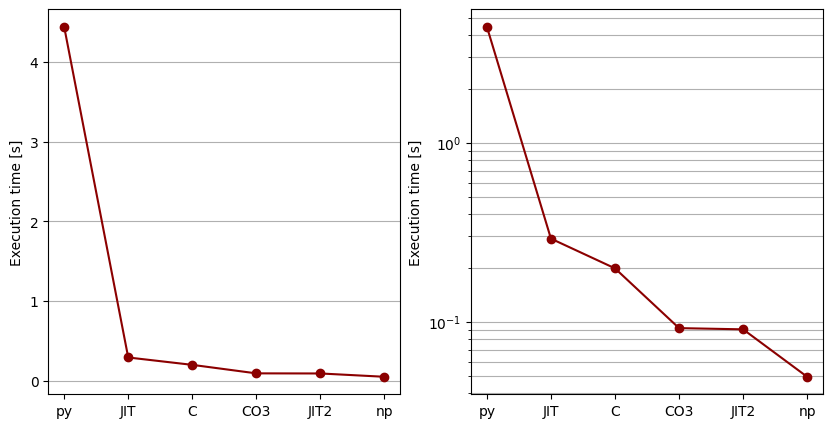

In [42]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots(1,2, figsize=(10,5))
ax[0].plot(method, dt_val, 'o-', color='darkred')
ax[0].grid(axis='y')

ax[1].plot(method, dt_val, 'o-', color='darkred')
ax[1].set_yscale('log')
ax[1].grid(axis='y', which='both')
for a in ax:
    a.set_ylabel('Execution time [s]')